(reserve-market-example)=
# Reserve capacity markets

The model setup for the reserve capacity examples presented below are available in the following formats.

- pyshop
    - [reserve.py](reserve-cap-py)

## Introduction
This example uses the same topology as the [reserve capacity allocation example](reserve-example): A simple system with 6 [generators](generator) located on two separate [plants](plant). Instead of just distributing a predetermined reserve capacity obligation between the generators, this example will add reserve capacity [markets](market) where reserve capacity can be sold.

## Model without reserve market
First, we create and run the basic model without any reserve requirements.

In [1]:
#Necessary imports used in all examples
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from pyshop import ShopSession

#Functions used in this example for building and solving a simple model with cuts
from reserve import build_model, run_model

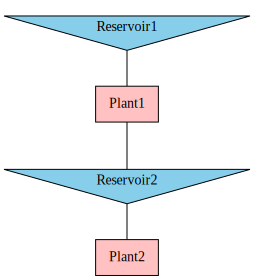

In [2]:
#Create a standard ShopSession
shop=ShopSession()
#Build a simple model with two reservoirs, two plants, and 6 generators.
build_model(shop)
#Display topology to the screen
display(shop.model.build_connection_tree())

#Run an optimization without any reserve markets
run_model(shop)

The resulting production on all generators in the system is shown in the figure below

In [3]:
sum_prod = None

fig = go.Figure()
fig.update_layout(barmode="stack", title="Production without reserve market", yaxis_title="Production [MWh]",colorway=px.colors.qualitative.Vivid)

for gen in shop.model.generator:
    prod = gen.production.get()
    if sum_prod is None:
        sum_prod = prod
    else: 
        sum_prod += prod
    fig.add_trace(go.Bar(x=prod.index, y=prod.values,name=gen.get_name(),offset=0.5))
fig.show()

## Model with reserve market

Now we create an identical SHOP model but add a [](reserve_group) object that we connect to all generators in the system. A reserve obligation of 0 MW of FRR-up is specified with the [frr_up_obligation](reserve_group:frr_up_obligation) attribute on the reserve_group. This input is necessary to let SHOP know which reserve types can be delivered in the reserve group, even though the obligation is zero.

In [4]:
#Create a new shop session
shop=ShopSession()
build_model(shop)

#Add reserve_group object to the original model
frr_up_group = shop.model.reserve_group.add_object("frr_up_group")
frr_up_group.frr_up_obligation.set(0)

#Connect all generators to the first group
for gen in shop.model.generator:
    gen.connect_to(frr_up_group)

A new market object where FRR-up capacity can be sold is created below. The [market_type](market:market_type) attribute must be specified to let SHOP know what type of reserve capacity that can be sold in the market. A [sale_price](market:sale_price) and [max_sale](market:max_sale) is defined to allow selling capacity, but there is no possibility to buy reserve capacity in the market. The sale_price is set to a constant 5 €/MW, and the max_sale value is set to a large number so that all available capacity could be sold to the market. Finally, the market is connected to the reserve_group. Only the units in the connected reserve_group may participate in the reserve market.

In [5]:
frr_up_market = shop.model.market.add_object("FRR-up-market")
frr_up_market.market_type.set("FRR_UP")
frr_up_market.sale_price.set(5)
frr_up_market.max_sale.set(10000)

frr_up_group.connect_to(frr_up_market)

The model is optimized, and the difference between the production in this run and the previous run without a reserve market is shown in the figure below.

In [6]:
#Optimize model
run_model(shop) 

#Plot production and the production from the previous run
fig = go.Figure()
fig.update_layout(barmode="stack", title="Production with reserve market", yaxis_title="Production [MWh]",colorway=px.colors.qualitative.Vivid)

for gen in shop.model.generator:
    prod = gen.production.get()
    fig.add_trace(go.Bar(x=prod.index, y=prod.values,name=gen.get_name(),offset=0.5))
fig.add_trace(go.Scatter(x=sum_prod.index, y=sum_prod.values,name="Sum production without reserves",line_shape="hv",line=dict(color="black")))

fig.show()

The optimal production set points have shifted due to the sale of FRR-up capacity. Note that hours with high production in the previous run generally has a lower production in the run with a reserve capacity market, this is to hold back some capacity to sell to the reserve market. The opposite is true for periods with an originally low production, here more units are kept online to sell FRR-up capacity instead of shutting down.

The figure below shows the FRR-up capacity sold to the market and the energy market sale price. There is a clear correlation where reserve capacity is sold in periods with a low energy price, and vice versa.

In [7]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(barmode="stack", title="FRR-up delivery",colorway=px.colors.qualitative.Vivid)
fig.update_yaxes(title_text="Energy price [€/MWh]", secondary_y=True)
fig.update_yaxes(title_text="FRR capacity [MW]", secondary_y=False)

for gen in shop.model.generator:
    frr_up = gen.frr_up_delivery.get()
    fig.add_trace(go.Bar(x=frr_up.index, y=frr_up.values,name=gen.get_name(),offset=0.5), secondary_y=False)

sale = -frr_up_market.sale.get()
fig.add_trace(go.Scatter(x=sale.index, y=sale.values, name="Total FRR-up sale",line_shape="hv",line=dict(color="red")), secondary_y=False)
    
energy_price = shop.model.market["Day_ahead"].sale_price.get()
fig.add_trace(go.Scatter(x=energy_price.index, y=energy_price.values, name="Energy price",line_shape="hv", marker=dict(color="black")), secondary_y=True)
        
fig.show()

The following plots give a more detailed look at the individual generator production and reserve capacity results. Note that all available capacity between the production level and the calculated [head-dependent max production](generator:max_prod_individual) is sold as FRR-up to the market. SHOP does not see any consequence of selling all of the capacity to the market since no activation constraints have been applied.

In [8]:
for gen in shop.model.generator:
    name = gen.get_name()
    p_min = gen.min_prod_individual.get()
    p_max = gen.max_prod_individual.get()
    prod = gen.production.get()
    frr_up = gen.frr_up_delivery.get()
        
    t = prod.index
    
    fig = go.Figure(layout={'title':"Production and reserves: "+name,'xaxis_title':"Time",'yaxis_title':"Production and reserves [MW]"})
    
    fig.add_trace(go.Scatter(name="P_min",x=t,y=p_min.values,line={'color': "black", 'width': 1,'dash':"dash"},line_shape='hv'))    
    fig.add_trace(go.Scatter(name="P_max",x=t,y=p_max.values,line={'color': "black", 'width': 1,'dash':"dash"},line_shape='hv'))    
    fig.add_trace(go.Scatter(name="Production",x=t,y=prod.values,line={'color': "black", 'width': 1},line_shape='hv'))    

    fig.add_trace(go.Scatter(showlegend=False,x=t,y=prod.values,line={'color': "black", 'width': 0},line_shape='hv'))    
    fig.add_trace(go.Scatter(name="FRR up",x=t,y=prod+frr_up, fill='tonexty',line={'color': "blue", 'width': 0},line_shape='hv'))    
    
    fig.show()